# Analyse einer PV-Anlage

Dieses Notebook analysiert die Produktions- und Verbrauchsdaten einer Photovoltaik-Anlage. Es werden folgende Aspekte untersucht:

- Tägliche Energieproduktion und Verbrauch
- Durchschnittlicher Tagesverlauf
- Analyse der Eigenversorgung und Energiebilanz

## Daten importieren und vorbereiten

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

### Daten einlesen
Wir lesen die Daten aus drei CSV-Dateien (A.csv, B.csv, C.csv) und führen sie zusammen.

In [2]:
# Daten einlesen
df_a = pd.read_csv('data/A.csv', parse_dates=['Timestamp'])
df_b = pd.read_csv('data/B.csv', parse_dates=['Timestamp'])
df_c = pd.read_csv('data/C.csv', parse_dates=['Timestamp'])

# Daten zusammenführen
dfs = [df_a, df_b, df_c]
df = pd.concat(dfs, axis=0)
df = df.sort_values('Timestamp').reset_index(drop=True)

# Zeige die ersten Zeilen des zusammengeführten Datensatzes
df.head()

,Timestamp,Generation_kW,Grid_Feed-In_kW,Grid_Supply_kW,Overall_Consumption_Calc_kW
0,2019-01-01 00:00:00,0.0,0.0,4.212,4.212
1,2019-01-01 00:00:00,NaN,0.0,2.800,NaN
2,2019-01-01 00:00:00,0.0,0.0,5.400,5.400
3,2019-01-01 00:15:00,0.0,0.0,4.212,4.212
4,2019-01-01 00:15:00,NaN,0.0,2.800,NaN


### Tägliche Summen berechnen
Wir aggregieren die Daten auf Tagesebene, um die täglichen Summen für Produktion und Verbrauch zu analysieren.

In [3]:
# Tägliche Summen berechnen
df['Date'] = df['Timestamp'].dt.date
daily_sums = df.groupby('Date').agg({
    'Generation_kW': 'sum',
    'Grid_Supply_kW': 'sum',
    'Grid_Feed-In_kW': 'sum',
    'Overall_Consumption_Calc_kW': 'sum'
}).reset_index()

daily_sums.head()

,Date,Generation_kW,Grid_Supply_kW,Grid_Feed-In_kW,Overall_Consumption_Calc_kW
0,2019-01-01,368.560,1278.776,155.312,1088.024
1,2019-01-02,886.412,1059.700,534.504,1109.208
2,2019-01-03,931.004,1502.120,345.040,1804.284
3,2019-01-04,1007.944,1609.452,319.040,1947.356
4,2019-01-05,9.048,1231.536,0.000,1016.184


## Visualisierungen

### 1. Tägliche Energieproduktion vs. Verbrauch

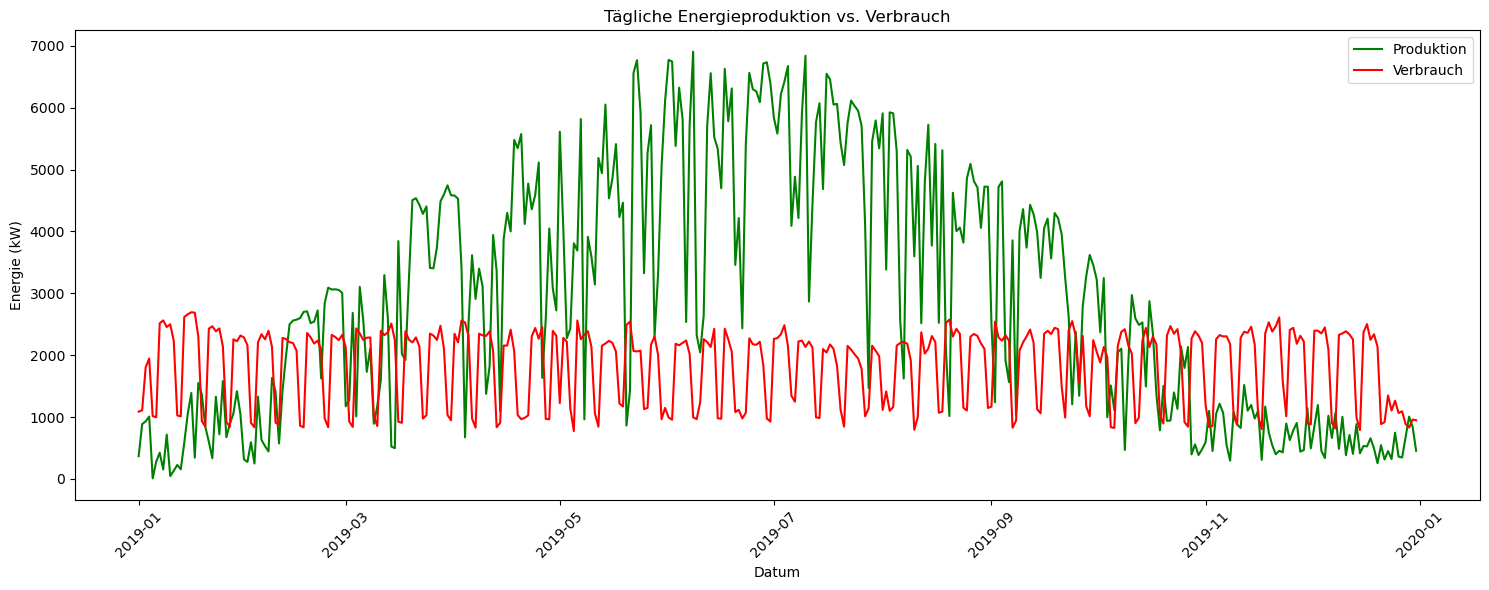

In [4]:
plt.figure(figsize=(15, 6))
plt.plot(daily_sums['Date'], daily_sums['Generation_kW'], label='Produktion', color='green')
plt.plot(daily_sums['Date'], daily_sums['Overall_Consumption_Calc_kW'], label='Verbrauch', color='red')
plt.title('Tägliche Energieproduktion vs. Verbrauch')
plt.xlabel('Datum')
plt.ylabel('Energie (kW)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

### 2. Durchschnittlicher Tagesverlauf
Dieser Plot zeigt den durchschnittlichen Verlauf von Produktion und Verbrauch über einen Tag.

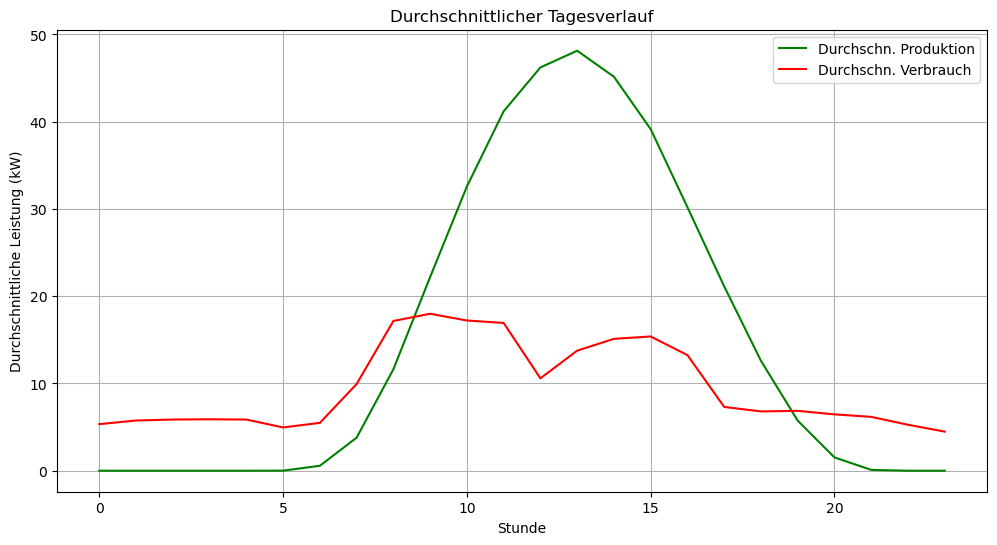

In [5]:
# Durchschnittlichen Tagesverlauf berechnen
df['Hour'] = df['Timestamp'].dt.hour
hourly_avg = df.groupby('Hour').agg({
    'Generation_kW': 'mean',
    'Overall_Consumption_Calc_kW': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(hourly_avg['Hour'], hourly_avg['Generation_kW'], label='Durchschn. Produktion', color='green')
plt.plot(hourly_avg['Hour'], hourly_avg['Overall_Consumption_Calc_kW'], label='Durchschn. Verbrauch', color='red')
plt.title('Durchschnittlicher Tagesverlauf')
plt.xlabel('Stunde')
plt.ylabel('Durchschnittliche Leistung (kW)')
plt.legend()
plt.grid(True)

## Analyse der Eigenversorgung
Wir untersuchen, an wie vielen Tagen die Eigenproduktion den Verbrauch decken konnte und berechnen die Gesamtenergiebilanz.

In [6]:
# Analyse der Eigenversorgung
daily_sums['self_sufficient'] = daily_sums['Generation_kW'] >= daily_sums['Overall_Consumption_Calc_kW']
self_sufficient_days = daily_sums['self_sufficient'].sum()
total_days = len(daily_sums)

print(f"Analyseergebnisse:")
print(f"Gesamtzahl der Tage: {total_days}")
print(f"Tage mit ausreichender Eigenproduktion: {self_sufficient_days}")
print(f"Prozentsatz der Tage mit Eigenversorgung: {(self_sufficient_days/total_days)*100:.2f}%")

# Energiebilanz
total_production = daily_sums['Generation_kW'].sum()
total_consumption = daily_sums['Overall_Consumption_Calc_kW'].sum()
print(f"\nGesamtproduktion: {total_production:.2f} kW")
print(f"Gesamtverbrauch: {total_consumption:.2f} kW")
print(f"Energiebilanz: {((total_production/total_consumption)*100):.2f}% des Verbrauchs wird durch Eigenproduktion gedeckt")

Analyseergebnisse:
Gesamtzahl der Tage: 365
Tage mit ausreichender Eigenproduktion: 229
Prozentsatz der Tage mit Eigenversorgung: 62.74%

Gesamtproduktion: 1056566.47 kW
Gesamtverbrauch: 671094.26 kW
Energiebilanz: 157.44% des Verbrauchs wird durch Eigenproduktion gedeckt


# TSM Plot (Sandra)
# Verlustleistung messen (Abi)
# Verbrauch auf Tag (Sheena)